# Capstone Project - Predicting Smartphone Purchase of Multi Category Store

This capstone project is to predict the future sales and customer purchase of an e-commerce multi category store. Of particular interest is the prediction of smartphone products, the core product of the business. The e-commerce B2C industry is highly competitive, imposing immense challenges to business sustainability. With accurate prediction of if smartphone is purchased in sessions, the business can increase revenue and profits by adopting effective real-time marketing strategies and efficient inventory management can be implemented

## Part 1 - Generate datasets and EDA

### Table of Contents

* [Section 1.  Import dataset](#section1)
    * [1.1 Read csv filess](#section_1_1)
    * [1.2 Cleaning data and parse features](#section_1_2)
* [Section 2. Generate datasets](#section2)
    * [2.1 Sessions](#section_2_1)
    * [2.2 Product features and attributes](#section_2_2)
    * [2.3 Sessions and products](#section_2_3)
* [Section 3. Exploratory data analysis](#section3)
    * [3.1 Session analysis](#section_3_1)
    * [3.2 Product analysis](#section_3_2)
    * [3.3 Category analysis](#section_3_3)


## Section 1.  Import dataset <a class="anchor" id="section1"></a> 

- The dataset is sourced from Kaggle. The link is provided below:
https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store

- The data consists of two months (Oct - Nov 2019) of customer’s sessions with a total 109M instances.

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# Garbage Collector to free up memory
import gc                         
gc.enable()                       # Activate 

### Section 1.1 Read csv files <a class="anchor" id="section_1_1"></a>
Define feature name and data type

In [2]:
column_name_and_dtype = {'event_type': 'category',
                         'product_id': 'category',
                         'category_id': 'category',
                         'category_code': 'category',
                         'brand': 'category',
                         'user_id': 'category',
                         'user_session': 'category'}

use_columns = ['event_time',
               'event_type',
               'product_id',
               'price',
               'category_code',
               'brand',
               'user_id',
               'user_session',
              ]

In [3]:
%%time
df = pd.read_csv('input/2019-Oct.csv',
                 dtype = column_name_and_dtype,
                 usecols = use_columns,
                 parse_dates = ['event_time'])


Wall time: 7min 51s


In [4]:
%%time
df_next = pd.read_csv('input/2019-Nov.csv',
                     dtype = column_name_and_dtype,
                     usecols = use_columns,
                     parse_dates = ['event_time'])


Wall time: 11min 11s


delete dataframe to free up memory

In [5]:
df = pd.concat([df, df_next]).reset_index(drop=True)

del df_next
gc.collect()

22

### Section 1.2 Cleaning data and parse features <a class="anchor" id="section_1_2"></a>

Drop instances with any missing values

In [6]:
display(df.shape)
df.dropna(how = 'any', inplace = True)
display(df.shape)

(109950743, 8)

(68650184, 8)

Find the number of unique values of each feature

In [7]:
data = [df[x].nunique() for x in df.columns]
pd.DataFrame({'unique numbers': data}, index = df.columns)

,unique numbers
event_time,5067534
event_type,3
product_id,74532
category_code,129
brand,2044
price,67532
user_id,4167673
user_session,15957931


Convert the three event types into three features indicated by column name

In [8]:
df['views'] = (df['event_type'] == 'view').astype('int8')
df['carts'] = (df['event_type'] == 'cart').astype('int8')
df['sales'] = (df['event_type'] == 'purchase').astype('int8')

### Section 2.  Generate datasets <a class="anchor" id="section2"></a> 

Filter the sessions containing "cart" or "purchase" activities, store in 'filtered.

In [9]:
filtered = df[df['carts'] + df['sales'] > 0]
filtered = df[df['user_session'].isin(filtered['user_session'].unique())]

In [10]:
filtered.shape

(15826938, 11)

In [11]:
df_snp = filtered.groupby(['user_session', 'product_id']) \
                 .agg(session_count = ('user_session' , 'count'),
                      views = ('views', 'sum'),
                      carts = ('carts', 'sum'),
                      sales = ('sales', 'sum'),
                      is_purchased = ('sales', 'max'),
                      is_cart = ('carts', 'max'),
                      price = ('price', 'first'),
                      time_min = ('event_time' , 'min'),
                      time_max = ('event_time' , 'max')) \
                 .reset_index()

df_snp['session_duration'] = (df_snp['time_max'] - df_snp['time_min']).dt.total_seconds().astype(int)


### Section 2.1 Sessions <a class="anchor" id="section_2_1"></a>

In [12]:
df_session = filtered.groupby(['user_session']) \
                     .agg(session_count = ('user_session' , 'count'),
                          views = ('views', 'sum'),
                          carts = ('carts', 'sum'),
                          sales = ('sales', 'sum'),
                          time_min = ('event_time' , 'min'),
                          time_max = ('event_time' , 'max'),
                          is_purchased = ('sales', 'max'),
                          is_cart = ('carts', 'max')) \
                     .reset_index()

df_session['session_duration'] = (df_session['time_max'] - df_session['time_min']).dt.total_seconds().astype(int)
df_session.head()

,user_session,session_count,views,carts,sales,time_min,time_max,is_purchased,is_cart,session_duration
0,00000083-8816-4d58-a9b8-f52f54186edc,18,16.0,1.0,1,2019-10-06 11:24:45+00:00,2019-10-06 11:34:30+00:00,1,1,585
1,000001fd-1f89-45e8-a3ce-fe3218cabfad,11,6.0,4.0,1,2019-10-25 08:30:42+00:00,2019-10-25 08:39:11+00:00,1,1,509
2,00003d51-f077-4b44-a0cc-4e9282a439a1,38,35.0,3.0,0,2019-11-15 05:10:30+00:00,2019-11-15 05:33:11+00:00,0,1,1361
3,00003e3b-b365-4460-bf59-fcc0c1491c97,4,2.0,1.0,1,2019-11-11 03:35:08+00:00,2019-11-11 03:35:59+00:00,1,1,51
4,00004ada-8f93-49a6-956d-4ed71ae94791,6,4.0,0.0,2,2019-10-17 13:34:16+00:00,2019-10-17 13:38:42+00:00,1,0,266


In [13]:
df_snp.head()

,user_session,product_id,session_count,views,carts,sales,is_purchased,is_cart,price,time_min,time_max,session_duration
0,00000083-8816-4d58-a9b8-f52f54186edc,1003527,1,1,0.0,0,0,0,201.35,2019-10-06 11:28:34+00:00,2019-10-06 11:28:34+00:00,0
1,00000083-8816-4d58-a9b8-f52f54186edc,1004246,1,1,0.0,0,0,0,736.03,2019-10-06 11:30:41+00:00,2019-10-06 11:30:41+00:00,0
2,00000083-8816-4d58-a9b8-f52f54186edc,1004249,1,1,0.0,0,0,0,730.26,2019-10-06 11:30:18+00:00,2019-10-06 11:30:18+00:00,0
3,00000083-8816-4d58-a9b8-f52f54186edc,1004653,1,1,0.0,0,0,0,635.80,2019-10-06 11:27:05+00:00,2019-10-06 11:27:05+00:00,0
4,00000083-8816-4d58-a9b8-f52f54186edc,1004751,1,1,0.0,0,0,0,197.15,2019-10-06 11:26:53+00:00,2019-10-06 11:26:53+00:00,0


In [14]:
df_session.shape

(2010155, 10)

Count the number of sessions longer than 1 hour

In [21]:
df_session[df_session['session_duration']>3600*1].shape

(47288, 10)

Inspect some sessions

In [25]:
#df_session[df_session['user_session'] == '3b00665a-daff-4a2c-bba2-a152cc6e62c9']

In [23]:
#df_snp[df_snp['user_session'] == '3b00665a-daff-4a2c-bba2-a152cc6e62c9']

In [24]:
#df_session[df_session['sales']>50]

In [26]:
#df[df['user_session']=='68b52b9a-97c8-4525-aba2-604ede028da8'].head(29)

In [27]:
df['week_id'] = df['event_time'].dt.week.astype('int16')

### Section 2.2 Product features and attributes <a class="anchor" id="section_2_2"></a>

Filter the instances containing only products with "cart" or "purchase", store in 'filtered.

In [28]:
filtered = df[df['product_id'].isin(df_snp['product_id'].unique())]

In [29]:
df_counts  = filtered.groupby(['product_id', 'week_id']) \
                     .agg(views = ('views', 'sum'),
                          carts = ('carts', 'sum'),
                          sales = ('sales', 'sum')) \
                     .reset_index()

In [30]:
df_counts.sample(5)

,product_id,week_id,views,carts,sales
393297,9002709,42,10.0,0.0,0.0
324907,50600013,47,49.0,0.0,0.0
248603,32900049,48,11.0,0.0,0.0
233764,28721811,45,103.0,0.0,0.0
333309,5700898,43,2.0,0.0,0.0


#### Calculate the weekly view counts and accumulated view counts of each product

In [31]:
df_views = pd.pivot_table(df_counts, values='views', index = 'product_id', columns='week_id', fill_value=0)
df_views_cumsum = df_views.cumsum(axis = 1)

df_views = pd.melt(df_views.reset_index(), id_vars = 'product_id', value_name = 'views')
df_views.rename(columns = {'views': 'views_last_1w'}, inplace = True)

df_views_cumsum = pd.melt(df_views_cumsum.reset_index(), id_vars = 'product_id', value_name = 'views')
df_views_cumsum.rename(columns = {'views': 'views_cumsum'}, inplace = True)

df_product = pd.merge(df_views, df_views_cumsum, on = ['product_id','week_id'])
df_product

,product_id,week_id,views_last_1w,views_cumsum
0,100000031,40,0,0
1,100000033,40,0,0
2,100000034,40,0,0
3,100000036,40,0,0
4,100000055,40,0,0
...,...,...,...,...
516901,9900458,48,8,53
516902,9900460,48,153,400
516903,9900461,48,18,230
516904,9900462,48,0,540


#### Calculate the weekly cart counts and accumulated cart counts of each product

In [32]:
df_carts = pd.pivot_table(df_counts, values='carts', index = 'product_id', columns='week_id', fill_value=0)
df_carts_cumsum = df_carts.cumsum(axis = 1)

df_carts = pd.melt(df_carts.reset_index(), id_vars = 'product_id', value_name = 'carts')
df_carts.rename(columns = {'carts': 'carts_last_1w'}, inplace = True)

df_carts_cumsum = pd.melt(df_carts_cumsum.reset_index(), id_vars = 'product_id', value_name = 'carts')
df_carts_cumsum.rename(columns = {'carts': 'carts_cumsum'}, inplace = True)

df_product = pd.merge(df_product, df_carts, on = ['product_id','week_id'])
df_product = pd.merge(df_product, df_carts_cumsum, on = ['product_id','week_id'])
df_product

,product_id,week_id,views_last_1w,views_cumsum,carts_last_1w,carts_cumsum
0,100000031,40,0,0,0,0
1,100000033,40,0,0,0,0
2,100000034,40,0,0,0,0
3,100000036,40,0,0,0,0
4,100000055,40,0,0,0,0
...,...,...,...,...,...,...
516901,9900458,48,8,53,0,0
516902,9900460,48,153,400,2,5
516903,9900461,48,18,230,0,12
516904,9900462,48,0,540,0,12


#### Calculate the weekly sale counts and accumulated sale counts of each product

In [33]:
df_sales = pd.pivot_table(df_counts, values='sales', index = 'product_id', columns='week_id', fill_value=0)
df_sales_cumsum = df_sales.cumsum(axis = 1)

df_sales = pd.melt(df_sales.reset_index(), id_vars = 'product_id', value_name = 'sales')
df_sales.rename(columns = {'sales': 'sales_last_1w'}, inplace = True)

df_sales_cumsum = pd.melt(df_sales_cumsum.reset_index(), id_vars = 'product_id', value_name = 'sales')
df_sales_cumsum.rename(columns = {'sales': 'sales_cumsum'}, inplace = True)

df_product = pd.merge(df_product, df_sales, on = ['product_id','week_id'])
df_product = pd.merge(df_product, df_sales_cumsum, on = ['product_id','week_id'])
df_product

,product_id,week_id,views_last_1w,views_cumsum,carts_last_1w,carts_cumsum,sales_last_1w,sales_cumsum
0,100000031,40,0,0,0,0,0,0
1,100000033,40,0,0,0,0,0,0
2,100000034,40,0,0,0,0,0,0
3,100000036,40,0,0,0,0,0,0
4,100000055,40,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
516901,9900458,48,8,53,0,0,0,0
516902,9900460,48,153,400,2,5,1,1
516903,9900461,48,18,230,0,12,0,0
516904,9900462,48,0,540,0,12,0,2


#### Calculate the ratio of cart (or sale) to view counts (i.e., conversion rate)

In [34]:
df_product.loc[:,'week_id'] = df_product['week_id'] + 1
df_product = df_product[df_product['week_id'] < df_product['week_id'].max()]
df_product.loc[:,'r_carts_last_1w'] = df_product['carts_last_1w'] / df_product['views_last_1w']
df_product.loc[:,'r_carts_cumsum'] = df_product['carts_cumsum'] / df_product['views_cumsum']
df_product.loc[:,'r_sales_last_1w'] = df_product['sales_last_1w'] / df_product['views_last_1w']
df_product.loc[:,'r_sales_cumsum'] = df_product['sales_cumsum'] / df_product['views_cumsum']
df_product

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,product_id,week_id,views_last_1w,views_cumsum,carts_last_1w,carts_cumsum,sales_last_1w,sales_cumsum,r_carts_last_1w,r_carts_cumsum,r_sales_last_1w,r_sales_cumsum
0,100000031,41,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,100000033,41,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2,100000034,41,0,0,0,0,0,0,NaN,NaN,NaN,NaN
3,100000036,41,0,0,0,0,0,0,NaN,NaN,NaN,NaN
4,100000055,41,0,0,0,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
459467,9900458,48,27,45,0,0,0,0,0.000000,0.000000,0.0,0.000000
459468,9900460,48,149,247,2,3,0,0,0.013423,0.012146,0.0,0.000000
459469,9900461,48,50,212,3,12,0,0,0.060000,0.056604,0.0,0.000000
459470,9900462,48,21,540,0,12,0,2,0.000000,0.022222,0.0,0.003704


In [35]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459472 entries, 0 to 459471
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   product_id       459472 non-null  object 
 1   week_id          459472 non-null  object 
 2   views_last_1w    459472 non-null  int64  
 3   views_cumsum     459472 non-null  int64  
 4   carts_last_1w    459472 non-null  int64  
 5   carts_cumsum     459472 non-null  int64  
 6   sales_last_1w    459472 non-null  int64  
 7   sales_cumsum     459472 non-null  int64  
 8   r_carts_last_1w  358233 non-null  float64
 9   r_carts_cumsum   390250 non-null  float64
 10  r_sales_last_1w  358233 non-null  float64
 11  r_sales_cumsum   390250 non-null  float64
dtypes: float64(4), int64(6), object(2)
memory usage: 45.6+ MB


### Section 2.3 Sessions and products <a class="anchor" id="section_2_3"></a>

In [36]:
df_snp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5801231 entries, 0 to 5801230
Data columns (total 12 columns):
 #   Column            Dtype              
---  ------            -----              
 0   user_session      object             
 1   product_id        object             
 2   session_count     int64              
 3   views             int8               
 4   carts             float64            
 5   sales             int8               
 6   is_purchased      int8               
 7   is_cart           int8               
 8   price             float64            
 9   time_min          datetime64[ns, UTC]
 10  time_max          datetime64[ns, UTC]
 11  session_duration  int32              
dtypes: datetime64[ns, UTC](2), float64(2), int32(1), int64(1), int8(4), object(2)
memory usage: 354.1+ MB


In [37]:
df_snp['week_id'] = df_snp['time_min'].dt.week.astype('int8')
df_snp['weekday'] = df_snp['time_min'].dt.weekday.astype('int8')

In [38]:
df_snp = df_snp.merge(df_product, how = 'left', on = ['product_id', 'week_id'])

In [39]:
df_snp.fillna(0, inplace = True)

In [40]:
df_snp.columns

Index(['user_session', 'product_id', 'session_count', 'views', 'carts',
       'sales', 'is_purchased', 'is_cart', 'price', 'time_min', 'time_max',
       'session_duration', 'week_id', 'weekday', 'views_last_1w',
       'views_cumsum', 'carts_last_1w', 'carts_cumsum', 'sales_last_1w',
       'sales_cumsum', 'r_carts_last_1w', 'r_carts_cumsum', 'r_sales_last_1w',
       'r_sales_cumsum'],
      dtype='object')

In [41]:
df_product = filtered.groupby(['product_id']) \
                     .agg(views = ('views', 'sum'),
                          carts = ('carts', 'sum'),
                          sales = ('sales', 'sum'),
                          price = ('price', 'mean'),
                          category = ('category_code', 'first'),
                          product = ('category_code', 'first'),
                          brand = ('brand', 'first')) \
                     .reset_index()

In [42]:
df_product['category'] = df_product['category'].apply(lambda x: x.split('.')[0])
df_product['product'] = df_product['product'].apply(lambda x: x.split('.')[-1])


In [43]:
df_product['cart_view_ratio'] = df_product['carts'] / df_product['views']
df_product['sale_view_ratio'] = df_product['sales'] / df_product['views']
df_product.sample(10)

,product_id,views,carts,sales,price,category,product,brand,cart_view_ratio,sale_view_ratio
7559,12201958,117.0,0.0,0.0,527.141709,sport,bicycle,lg,0.000000,0.000000
30850,28715734,112.0,0.0,0.0,100.743750,apparel,shoes,rieker,0.000000,0.000000
9224,12400468,330.0,2.0,1.0,287.102823,construction,drill,makita,0.006061,0.003030
12962,14700332,1470.0,14.0,8.0,459.234611,furniture,cabinet,brw,0.009524,0.005442
21222,21408824,21.0,0.0,0.0,168.663810,electronics,clocks,boccia,0.000000,0.000000
16,100000159,302.0,11.0,4.0,68.210000,apparel,shoes,respect,0.036424,0.013245
21277,21408937,189.0,0.0,3.0,32.430000,electronics,clocks,casio,0.000000,0.015873
25112,2501106,197.0,14.0,0.0,679.530000,appliances,oven,electrolux,0.071066,0.000000
7177,12200204,54.0,1.0,0.0,248.258000,sport,bicycle,matrix,0.018519,0.000000
28971,28705372,82.0,0.0,0.0,37.070000,apparel,shoes,remonte,0.000000,0.000000


In [44]:
df_snp = df_snp.merge(df_product[['product_id', 'category', 'product', 'brand']],
                      how = 'left',
                      on = ['product_id'])

In [45]:
%%time
df_snp.to_csv('csv_files/session_and_product.gz', 
              index = False, 
              compression = 'gzip')


Wall time: 5min 17s


In [46]:
#data = [df_snp[x].nunique() for x in df_snp.columns]
#pd.DataFrame({'unique numbers': data}, index = df_snp.columns)

In [47]:
df_snp.shape

(5801231, 27)

In [48]:
df_snp.corr()


,session_count,views,carts,sales,is_purchased,is_cart,price,session_duration,week_id,weekday,views_last_1w,views_cumsum,carts_last_1w,carts_cumsum,sales_last_1w,sales_cumsum,r_carts_last_1w,r_carts_cumsum,r_sales_last_1w,r_sales_cumsum
session_count,1.000000,0.841189,0.737945,0.450558,0.397211,0.559956,-0.005505,0.053324,0.000236,-0.010523,0.102599,0.093527,0.086740,0.086233,0.097428,0.085928,0.129362,0.139961,0.117913,0.126607
views,0.841189,1.000000,0.299278,0.196246,0.155898,0.300257,-0.026608,0.061171,0.000622,0.003235,0.011225,0.006628,0.007699,0.003846,0.006992,0.002355,0.024840,0.027046,0.015018,0.019345
carts,0.737945,0.299278,1.000000,0.269518,0.241271,0.597680,0.015083,0.018183,0.046247,-0.001681,0.140060,0.137173,0.117095,0.125474,0.132076,0.127361,0.167154,0.180771,0.147869,0.162734
sales,0.450558,0.196246,0.269518,1.000000,0.931486,0.367537,0.024234,0.022187,-0.120563,-0.062418,0.140232,0.115769,0.128175,0.117187,0.148288,0.115867,0.164165,0.177221,0.187706,0.180121
is_purchased,0.397211,0.155898,0.241271,0.931486,1.000000,0.387262,0.023421,0.010916,-0.127833,-0.066132,0.145828,0.120242,0.133307,0.121561,0.154163,0.120138,0.170976,0.184260,0.195945,0.187702
is_cart,0.559956,0.300257,0.597680,0.367537,0.387262,1.000000,0.038358,0.016691,0.076170,-0.012418,0.218687,0.213278,0.182359,0.193764,0.206559,0.197098,0.263100,0.281787,0.234576,0.256118
price,-0.005505,-0.026608,0.015083,0.024234,0.023421,0.038358,1.000000,-0.000687,-0.027829,-0.004090,0.088470,0.075275,0.009060,-0.008864,0.023157,0.011684,-0.004308,0.020344,0.049102,0.064540
session_duration,0.053324,0.061171,0.018183,0.022187,0.010916,0.016691,-0.000687,1.000000,-0.005091,-0.001045,-0.000361,-0.001058,-0.000539,-0.001021,-0.000460,-0.001085,0.000090,0.000387,0.000146,0.000117
week_id,0.000236,0.000622,0.046247,-0.120563,-0.127833,0.076170,-0.027829,-0.005091,1.000000,0.064059,0.110696,0.231176,0.121168,0.202224,0.055803,0.180771,0.219294,0.170278,-0.008705,0.051831
weekday,-0.010523,0.003235,-0.001681,-0.062418,-0.066132,-0.012418,-0.004090,-0.001045,0.064059,1.000000,-0.061319,-0.045531,-0.071029,-0.053114,-0.061848,-0.040173,-0.131265,-0.107417,-0.102079,-0.078618


In [49]:
df_snp['is_purchased'].value_counts()

0    4680920
1    1120311
Name: is_purchased, dtype: int64

## Section 3.  Exploratory data analysis  <a class="anchor" id="section3"></a>

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

### Section 3.1 Session analysis <a class="anchor" id="section_3_1"></a>

In [51]:
df_session['is_purchased'] = df_session['is_purchased'].map({1: 'purchased', 0: 'cart'})
df_session['weekday'] = df_session['time_min'].dt.weekday.astype('int16')
df_session['event_weekday'] = df_session['time_min'].dt.weekday.astype('int16')
df_session['event_hour'] = df_session['time_min'].dt.hour.astype('int16')
df_session['week_id'] = df_session['time_min'].dt.week.astype('int16')


In [52]:
df_session['is_purchased'].value_counts()

purchased    1025278
cart          984877
Name: is_purchased, dtype: int64

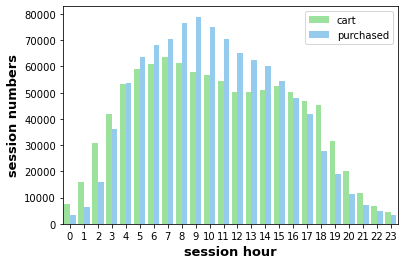

In [53]:
gp = df_session.groupby(['event_hour','is_purchased'])['time_min'].count().reset_index()

fig, ax = plt.subplots()
sns.barplot(x = 'event_hour', y = 'time_min', data = gp, hue = 'is_purchased', palette = ['lightgreen', 'lightskyblue'])

ax.set_xlabel('session hour', fontsize = 13, fontweight = 'bold')
ax.set_ylabel('session numbers', fontsize = 13, fontweight = 'bold')
ax.legend(title = '')
fig.savefig('output/event_hour.png', transparent=True, bbox_inches='tight', dpi=300)

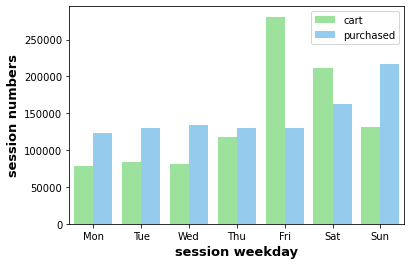

In [54]:
gp = df_session.groupby(['event_weekday','is_purchased'])['time_min'].count().reset_index()
fig, ax = plt.subplots()
sns.barplot(x = 'event_weekday', y = 'time_min', data = gp, hue = 'is_purchased', palette = ['lightgreen', 'lightskyblue'])

ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax.set_xlabel('session weekday', fontsize = 13, fontweight = 'bold')
ax.set_ylabel('session numbers', fontsize = 13, fontweight = 'bold')
ax.legend(title = '')
fig.savefig('output/event_weekday.png', transparent=True, bbox_inches='tight', dpi=300)

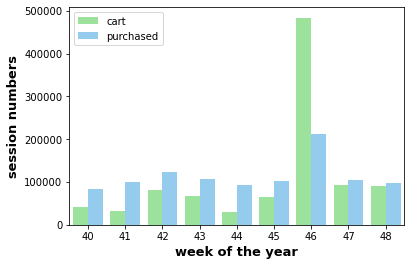

In [55]:
gp = df_session.groupby(['week_id','is_purchased'])['time_min'].count().reset_index()
fig, ax = plt.subplots()
sns.barplot(x = 'week_id', y = 'time_min', data = gp, hue = 'is_purchased', palette = ['lightgreen', 'lightskyblue']);

ax.set_xlabel('week of the year', fontsize = 13, fontweight = 'bold')
ax.set_ylabel('session numbers', fontsize = 13, fontweight = 'bold')
ax.legend(title = '')
fig.savefig('output/event_weekid.png', transparent=True, bbox_inches='tight', dpi=300)

In [56]:
df_session.describe().T

,count,mean,std,min,25%,50%,75%,max
session_count,2010155.0,7.873491,8.755924,1.0,3.0,5.0,9.0,534.0
views,2010155.0,5.817306,8.234298,0.0,2.0,3.0,6.0,531.0
carts,2010155.0,1.454857,1.870709,0.0,1.0,1.0,2.0,389.0
sales,2010155.0,0.601328,0.736820,0.0,0.0,1.0,1.0,85.0
is_cart,2010155.0,0.858842,0.348184,0.0,1.0,1.0,1.0,1.0
session_duration,2010155.0,724.008760,15070.850036,0.0,92.0,220.0,534.0,5056740.0
weekday,2010155.0,3.472576,1.928293,0.0,2.0,4.0,5.0,6.0
event_weekday,2010155.0,3.472576,1.928293,0.0,2.0,4.0,5.0,6.0
event_hour,2010155.0,10.435447,5.057758,0.0,6.0,10.0,14.0,23.0
week_id,2010155.0,44.708929,2.334716,40.0,43.0,46.0,46.0,48.0


In [57]:
df_session.sort_values(by = 'sales', ascending = False).head(5)

,user_session,session_count,views,carts,sales,time_min,time_max,is_purchased,is_cart,session_duration,weekday,event_weekday,event_hour,week_id
822497,68b52b9a-97c8-4525-aba2-604ede028da8,269,101.0,83.0,85,2019-11-17 03:45:40+00:00,2019-11-17 17:18:50+00:00,purchased,1,48790,6,6,3,46
228837,1d34878d-1a42-401b-90a4-d44e2aa1e127,251,95.0,80.0,76,2019-11-17 16:14:40+00:00,2019-11-17 18:00:36+00:00,purchased,1,6356,6,6,16,46
462855,3b00665a-daff-4a2c-bba2-a152cc6e62c9,163,65.0,40.0,58,2019-11-02 15:01:25+00:00,2019-11-02 16:33:01+00:00,purchased,1,5496,5,5,15,44
819875,6860e076-5d5f-4a7e-ac61-6d85706a262f,143,54.0,41.0,48,2019-10-06 06:36:44+00:00,2019-10-06 08:54:01+00:00,purchased,1,8237,6,6,6,40
117121,0eedef43-b496-46a8-a027-70bdb0c1ed22,172,111.0,20.0,41,2019-10-01 05:07:07+00:00,2019-10-08 06:18:43+00:00,purchased,1,609096,1,1,5,40


### Section 3.2 Product analysis <a class="anchor" id="section_3_2"></a>

In [66]:
df_product['name'] = df_product['brand'] + " " + df_product['product'] + " ($" + df_product['price'].round(2).astype('str') + ")"
df_product.set_index('name', inplace = True)
df_product.sample(5)

,product_id,views,carts,sales,price,category,product,brand,cart_view_ratio,sale_view_ratio
name,,,,,,,,,,
gorenje hob ($154.51),4502107,557.0,7.0,4.0,154.510528,appliances,hob,gorenje,0.012567,0.007181
greyder shoes ($54.06),28713539,23.0,0.0,0.0,54.060000,apparel,shoes,greyder,0.000000,0.000000
darina oven ($224.91),2501590,784.0,14.0,2.0,224.911687,appliances,oven,darina,0.017857,0.002551
asics keds ($129.99),28720249,15.0,0.0,0.0,129.990000,apparel,keds,asics,0.000000,0.000000
toshiba hdd ($67.82),6800943,94.0,0.0,0.0,67.821596,computers,hdd,toshiba,0.000000,0.000000


In [68]:
#df_product.sort_values(by = 'views', ascending = False).head(10)

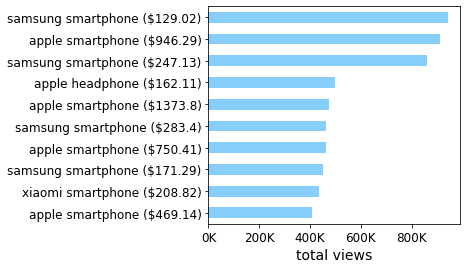

In [69]:
col = 'views'
fig, ax = plt.subplots(figsize =[4.5, 4])
df_product[col].sort_values(ascending = False) \
               .head(10).iloc[::-1] \
               .plot(kind = 'barh', fontsize = 12, color = 'lightskyblue')
ax.set_ylabel('')
ax.set_xlabel('total views', fontsize = 14)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
fig.savefig('output/product_total_views.png', transparent=True, bbox_inches='tight', dpi=300)

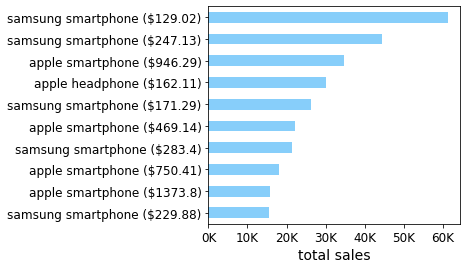

In [70]:
col = 'sales'
fig, ax = plt.subplots(figsize =[4.5, 4])
df_product[col].sort_values(ascending = False) \
               .head(10).iloc[::-1] \
               .plot(kind = 'barh', fontsize = 12, color = 'lightskyblue')
ax.set_ylabel('')
ax.set_xlabel('total sales', fontsize = 14)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
fig.savefig('output/product_total_sales.png', transparent=True, bbox_inches='tight', dpi=300)

31113

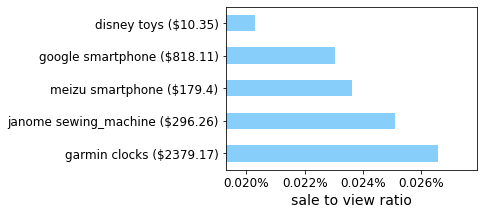

In [71]:
display(df_product[df_product['sale_view_ratio'] == 0].shape[0])

col = 'sale_view_ratio'
df_column = df_product[df_product[col] > 0][col].sort_values(ascending = True).head(5).iloc[::-1]
fig, ax = plt.subplots(figsize =[4.5, 3])
df_column.plot(kind = 'barh', fontsize = 12, xlim = [df_column.min()*0.95, df_column.max()*1.05], color = 'lightskyblue')
ax.set_ylabel('')
ax.set_xlabel('sale to view ratio', fontsize = 14)
xlabels = ['{:,.3f}'.format(x) + '%' for x in ax.get_xticks()*100]
ax.set_xticklabels(xlabels)
fig.savefig('output/product_lowest_sale_view_ratio.png', transparent=True, bbox_inches='tight', dpi=300)


In [72]:
df_product[df_product['sales'] > 200].sort_values(by = 'sale_view_ratio', ascending = False).head(10)

,product_id,views,carts,sales,price,category,product,brand,cart_view_ratio,sale_view_ratio
name,,,,,,,,,,
artel air_conditioner ($899.5),4201541,3025.0,202.0,238.0,899.502009,appliances,air_conditioner,artel,0.066777,0.078678
samsung smartphone ($129.02),1004856,942167.0,133328.0,61265.0,129.018019,electronics,smartphone,samsung,0.141512,0.065026
apple headphone ($162.11),4804056,497431.0,77400.0,30181.0,162.111926,electronics,headphone,apple,0.155599,0.060674
samsung smartphone ($171.29),1004833,450464.0,56048.0,26183.0,171.293802,electronics,smartphone,samsung,0.124423,0.058125
apple smartphone ($469.14),1002544,409169.0,43790.0,22227.0,469.137150,electronics,smartphone,apple,0.107022,0.054322
apple smartphone ($542.78),1002524,248725.0,27446.0,12877.0,542.782265,electronics,smartphone,apple,0.110347,0.051772
samsung smartphone ($247.13),1004767,861675.0,102215.0,44419.0,247.129489,electronics,smartphone,samsung,0.118624,0.051550
apple smartphone ($411.43),1005207,5531.0,514.0,273.0,411.429789,electronics,smartphone,apple,0.092931,0.049358
samsung smartphone ($229.88),1004836,323917.0,35750.0,15549.0,229.881855,electronics,smartphone,samsung,0.110368,0.048003


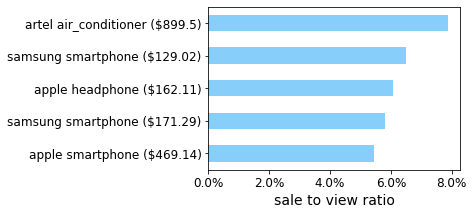

In [73]:
col = 'sale_view_ratio'
df_column = df_product[df_product['sales'] > 200][col].sort_values(ascending = False).head(5).iloc[::-1]
fig, ax = plt.subplots(figsize =[4.5, 3])
df_column.plot(kind = 'barh', fontsize = 12, color = 'lightskyblue')
ax.set_ylabel('')
ax.set_xlabel('sale to view ratio', fontsize = 14)
xlabels = ['{:,.1f}'.format(x) + '%' for x in ax.get_xticks()*100]
ax.set_xticklabels(xlabels)
fig.savefig('output/product_highest_sale_view_ratio.png', transparent=True, bbox_inches='tight', dpi=300)


[Text(0, 0, '0.0%'),
 Text(0, 0, '2.0%'),
 Text(0, 0, '4.0%'),
 Text(0, 0, '6.0%'),
 Text(0, 0, '8.0%'),
 Text(0, 0, '10.0%')]

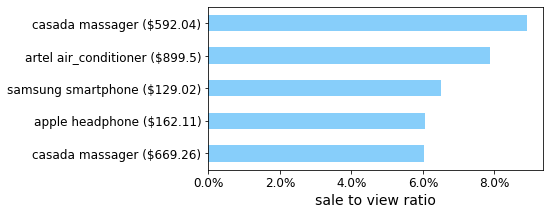

In [76]:
col = 'sale_view_ratio'
df_column = df_product[df_product['sales'] > 50][col].sort_values(ascending = False).head(5).iloc[::-1]
fig, ax = plt.subplots(figsize =[6, 3])
df_column.plot(kind = 'barh', fontsize = 12, color = 'lightskyblue')
ax.set_ylabel('')
ax.set_xlabel('sale to view ratio', fontsize = 14)
xlabels = ['{:,.1f}'.format(x) + '%' for x in ax.get_xticks()*100]
ax.set_xticklabels(xlabels)


In [77]:
df_product.sort_values(by = 'price', ascending = False).head(10)

,product_id,views,carts,sales,price,category,product,brand,cart_view_ratio,sale_view_ratio
name,,,,,,,,,,
rado clocks ($2574.07),21407288,1323.0,5.0,0.0,2574.070000,electronics,clocks,rado,0.003779,0.000000
rado clocks ($2574.07),21407287,1529.0,5.0,0.0,2574.070000,electronics,clocks,rado,0.003270,0.000000
acer desktop ($2574.04),1480527,2127.0,16.0,6.0,2574.040000,computers,desktop,acer,0.007522,0.002821
msi notebook ($2574.04),1307275,1623.0,3.0,4.0,2574.040000,computers,notebook,msi,0.001848,0.002465
haier refrigerators ($2574.04),2702129,364.0,2.0,0.0,2574.040000,appliances,refrigerators,haier,0.005495,0.000000
acer notebook ($2574.04),1306325,21.0,0.0,0.0,2574.040000,computers,notebook,acer,0.000000,0.000000
asus desktop ($2574.04),1480532,57.0,0.0,0.0,2574.040000,computers,desktop,asus,0.000000,0.000000
wacom tablet ($2574.04),18500024,34.0,0.0,0.0,2574.040000,electronics,tablet,wacom,0.000000,0.000000
teka coffee_machine ($2574.04),100012494,147.0,0.0,0.0,2574.040000,appliances,coffee_machine,teka,0.000000,0.000000


In [78]:
df_product.sort_values(by = 'price', ascending = True).head(10)

,product_id,views,carts,sales,price,category,product,brand,cart_view_ratio,sale_view_ratio
name,,,,,,,,,,
ritmix headphone ($0.88),4804539,3143.0,94.0,44.0,0.878488,electronics,headphone,ritmix,0.029908,0.013999
ritmix headphone ($0.88),4804536,1522.0,41.0,22.0,0.878915,electronics,headphone,ritmix,0.026938,0.014455
mutsy carriage ($0.9),7006416,101.0,0.0,5.0,0.900000,kids,carriage,mutsy,0.000000,0.049505
defender mouse ($1.0),21800236,8.0,0.0,0.0,1.000000,computers,mouse,defender,0.000000,0.000000
olto headphone ($1.0),4803174,713.0,31.0,25.0,1.000000,electronics,headphone,olto,0.043478,0.035063
olto headphone ($1.0),4803175,396.0,13.0,12.0,1.000000,electronics,headphone,olto,0.032828,0.030303
ritmix headphone ($1.13),4804577,254.0,3.0,3.0,1.126769,electronics,headphone,ritmix,0.011811,0.011811
ritmix headphone ($1.13),4804541,295.0,3.0,1.0,1.127492,electronics,headphone,ritmix,0.010169,0.003390
ritmix headphone ($1.13),4804535,242.0,0.0,1.0,1.127860,electronics,headphone,ritmix,0.000000,0.004132


### Section 3.3 Category analysis <a class="anchor" id="section_3_3"></a>

In [79]:
event_type = df['event_type'].value_counts()

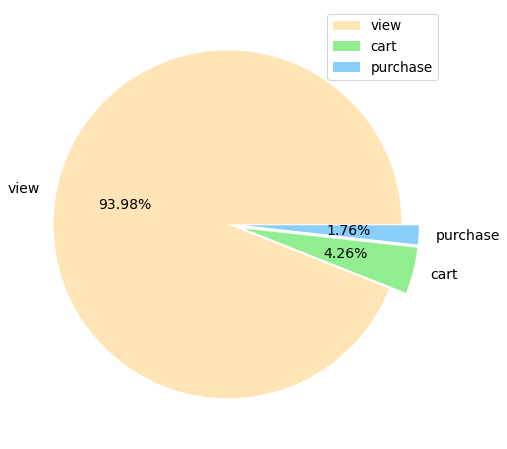

In [80]:
fig, ax = plt.subplots(figsize = [8,8])
#colors = ['yellowgreen', 'lightskyblue', 'lightcoral']
colors = ['moccasin', 'lightgreen', 'lightskyblue']
labels = ['view', 'cart','purchase']

#fig.pie(event_type, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.pie(event_type, explode = [0, 0.1,0.1], colors = colors, labels = labels, shadow = False, autopct = '%.2f%%', textprops={'fontsize': 14});
plt.legend(fontsize = 13.5)
fig.savefig('output/event_type_pie.png', transparent=True, bbox_inches='tight', dpi=300)
#fig.savefig('event_type_pie.png', transparent=True, dpi=300)


In [82]:
marker_list = ['o','v','^','<','>','8','s','p','P','*','h','H','D','+','X']
marker_map = dict(zip(df_product['category'].unique(), marker_list[:13]))
marker_map

{'furniture': 'o',
 'kids': 'v',
 'apparel': '^',
 'auto': '<',
 'electronics': '>',
 'computers': '8',
 'accessories': 's',
 'appliances': 'p',
 'construction': 'P',
 'sport': '*',
 'stationery': 'h',
 'medicine': 'H',
 'country_yard': 'D'}

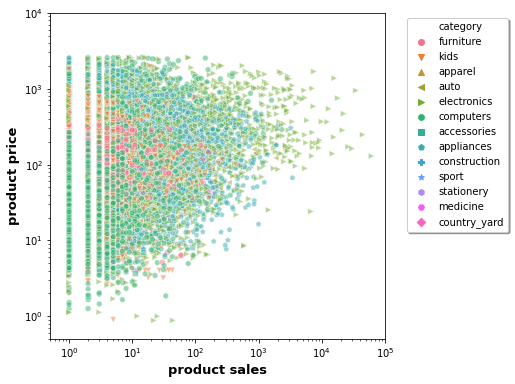

In [84]:
fig, ax = plt.subplots(figsize = [6,6])
sns.scatterplot(x = 'sales', 
                y = 'price',
                data = df_product,
                alpha = 0.5,
                markers = marker_map,
                hue = 'category',
                style = 'category',
#                cmap = plt.cm.get_cmap('tab20'),
#                palette = 'tab20c',
#                palette = 'Spectral',
                ax = ax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('product sales', fontsize=13, fontweight='bold')
ax.set_ylabel('product price', fontsize=13, fontweight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), fancybox=True, shadow=True)
ax.set_xlim([0.5,1e5])
ax.set_ylim([0.5,1e4])
fig.savefig('output/product_sales_and_price.png', transparent=False, bbox_inches='tight', dpi=300)

Calculate business annual revenue

In [85]:
annual_revenue = df.loc[df['sales'] > 0, 'price'].sum()*6/1e9
annual_revenue.round(3)

2.6725687849199993

In [87]:
df_product['category'].unique()

array(['furniture', 'kids', 'apparel', 'auto', 'electronics', 'computers',
       'accessories', 'appliances', 'construction', 'sport', 'stationery',
       'medicine', 'country_yard'], dtype=object)

In [88]:
df_product['product'].unique()

array(['pillow', 'toys', 'shoes', 'parktronic', 'underwear', 'player',
       'clocks', 'memory', 'subwoofer', 'videocards', 'bag',
       'water_heater', 'wallet', 'saw', 'air_heater', 'blender', 'dress',
       'drill', 'faucet', 'washer', 'notebook', 'fan', 'trousers',
       'scarf', 'hood', 'sofa', 'table', 'blanket', 'acoustic', 'iron',
       'massager', 'bed', 'headphone', 'desktop', 'cpu', 'alarm',
       'welding', 'keds', 'moccasins', 'sandals', 'grill', 'mouse',
       'printer', 'motherboard', 'tv', 'refrigerators', 'cabinet',
       'snowboard', 'skirt', 'dishwasher', 'bath', 'carriage', 'ski',
       'hob', 'oven', 'toilet', 'coffee_machine', 'chair', 'telephone',
       'anti_freeze', 'meat_grinder', 'trainer', 'costume', 'jumper',
       'scales', 'shirt', 'tshirt', 'bicycle', 'skates', 'power_supply',
       'cartrige', 'smartphone', 'microwave', 'videoregister', 'dolls',
       'pump', 'projector', 'cooler', 'keyboard', 'vacuum', 'video',
       'tablet', 'kettle', '

In [ ]:
df['category'] = df['category_code'].apply(lambda x: x.split('.')[0])

In [94]:
data = df.loc[df['sales'] > 0].groupby('category')['price'].sum()

In [99]:
df_category = pd.DataFrame(data).sort_values(by = 'price', ascending = False)
df_category

,price
category,
electronics,3.806476e+08
appliances,3.076484e+07
computers,2.516319e+07
auto,2.120182e+06
furniture,1.690758e+06
construction,1.582978e+06
apparel,1.448203e+06
kids,1.209916e+06
sport,5.945511e+05


In [89]:
%%time
df.to_csv('csv_files/dataset.gz', 
          index = False, 
          compression = 'gzip')


Wall time: 18min 38s


In [100]:
df_category.to_csv('output/category_summary.csv')